RNN
---

https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs

Both
GOOGL (Alphabet class A) and APPL (Apple), with transfer learning from one to the other

○Predict close value of each day
○So you don’t copy the winning Kaggle code, no LSTMs allowed
■(I know, but finding good public RNN data is hard)


My job is to predict the close value at each day for the google and aple stocks using a recurrent neural network. 


Part I: Data Cleaning
--------------------

Taking in dataset of apple stock, and cleaning it into a typical ML dataset

In [1]:
import csv
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time

/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def load_data(data, seq_len, normalise_window):
    data = data

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)  #randomizes so while it gets open and close, not doing just daily order 
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [3]:
data = pd.read_csv('aapl.us.txt')

In [4]:
data = data['Close']

In [5]:
X_train,y_train,X_test, y_test = load_data(data.values,50,True)   #Note it must be values, 

In [6]:
#Build Model, based on Siraj IDL 7
model = Sequential()

model.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : ', time.time() - start)

/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`


compilation time :  0.1126410961151123


/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


In [23]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=10,
    validation_split=0.05)

/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 7107 samples, validate on 375 samples
Epoch 1/10
7107/7107 [==============================] - 5s 742us/step - loss: 0.0051 - val_loss: 0.0064
Epoch 2/10
7107/7107 [==============================] - 5s 720us/step - loss: 0.0043 - val_loss: 0.0048
Epoch 3/10
7107/7107 [==============================] - 6s 821us/step - loss: 0.0042 - val_loss: 0.0047
Epoch 4/10
7107/7107 [==============================] - 6s 886us/step - loss: 0.0034 - val_loss: 0.0037
Epoch 5/10
7107/7107 [==============================] - 7s 920us/step - loss: 0.0034 - val_loss: 0.0038
Epoch 6/10
7107/7107 [==============================] - 6s 847us/step - loss: 0.0031 - val_loss: 0.0032
Epoch 7/10
7107/7107 [==============================] - 5s 764us/step - loss: 0.0028 - val_loss: 0.0030
Epoch 8/10
7107/7107 [==============================] - 6s 785us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 9/10
7107/7107 [==============================] - 6s 914us/step - loss: 0.0025 - val_loss: 0.0030
Epoch 10/10
7107/

In [24]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    print('yo')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()

In [25]:
from numpy import newaxis

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

yo


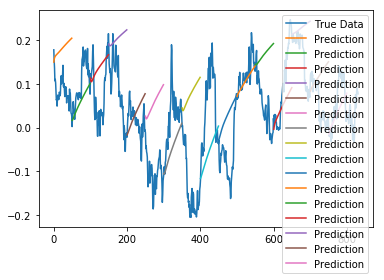

In [26]:
%matplotlib inline
predictions = predict_sequences_multiple(model, X_test, 50, 50)
plot_results_multiple(predictions, y_test, 50)

In [15]:
type(50)

int

Down here is the tensorflow version. It doesn't work so keeping with Keras stuff above

In [ ]:
data

In [ ]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)


In [ ]:
import tensorflow as tf
from tensorflow.contrib import rnn

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

In [ ]:
# Training Parameters
learning_rate = 0.001
training_steps = 10000
batch_size = 128
display_step = 200

# Network Parameters
num_input = 50 # MNIST data input (img shape: 28*28)
timesteps = 50 # timesteps
num_hidden = 128 # hidden layer num of features
num_classes = 1 # MNIST total classes (0-9 digits)

# tf Graph input
X = tf.placeholder("float", [None, timesteps, num_input])
Y = tf.placeholder("float", [None, num_classes])

In [ ]:
# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([num_hidden, num_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([num_classes]))
}

In [ ]:

def RNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, timesteps, 1)

    # Define a lstm cell with tensorflow
    lstm_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)

    # Get lstm cell output
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

In [ ]:
logits = RNN(X, weights, biases)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

#loss_op = tf.reduce_mean(tf.metrics.mean_squared_error(logits=logits, labels=Y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [ ]:
# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, training_steps+1):
        batch_x, batch_y = next_batch(batch_size,X_train,y_train)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, timesteps, num_input))
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, timesteps, num_input))
    test_label = mnist.test.labels[:test_len]
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: test_data, Y: test_label}))